# **Deep Convolutional GAN (DCGAN) implementation (20 points)**

In this laboratory work, you will be implementing the Deep Convolutional Generative Adversarial Network architecture (DCGAN). This task is based on the paper `Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks`. This paper by Alec Radford, Luke Metz, and Soumith Chintala was released in 2016 and has become the baseline for many Convolutional GAN architectures in deep learning. You will learn about the DCGAN architecture from the paper. After that, you will implement the model using PyTorch deep learning framework.

You will work with the CIFAR10 dataset and try to train models for generating similar images.

In [13]:
import torch
import torch.nn as nn
import torchvision.utils as vutils

if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

Tesla T4


In [2]:
# Create input and output folders
!mkdir input
!mkdir outputs

### **No Max Pooling**
DCGAN architecture is a fully convolutional network. This means that we will not use any max-pooling for downsampling. All of the operations will be through strided convolutions only.

### **Using Batch Normalization**
We will use batch normalization while building both, the discriminator and the generator. This mainly tackles two problems in DCGAN and in deep neural networks in general.

It normalizes the input to each unit of a layer.
It also helps to deal with poor initialization that may cause problems in gradient flow.

### **ReLU, LeakyReLU, and Tanh Activations**
We will use the ReLU activation function in all the layers of the generator, except for the last one. For the last convolutional layer, we will use Tanh activation function.

For the discriminator, we will use LeakyReLU for all the convolutional layer after applying batch normalization.

The above are the architectural details that the authors have provided in the paper. Applying these successfully while building our DCGAN model will surely help in more stable training.

### **Hyperparameters to Consider While Training**
Now, we will learn about the different parameters and hyperparameters that we can use while training DCGAN. Using the hyperparameter values as provided by the authors will give us the best results while training.

The very first one is the batch size. The authors used a batch size of $128$ for training DCGAN. While implementing the code, will use the same batch size as well.

We will also carry out weight initialization for the generator and discriminator networks. We will initialize the weights from a zero-centered Normal Distribution with a standard deviation of 0.02.

For the discriminator network, we will use the LeakyReLU activation. We will set the slope of the LeakyReLU activation to 0.2.

We will use the Adam optimizer for training DCGAN. The learning rate of Adam optimizer is going to be 0.0002. The Adam optimizer has a default momentum value β1 of 0.9. Instead of 0.9, we will set the value of β1 to 0.5. This helps in more stable training and faster convergence.

## **Generator**

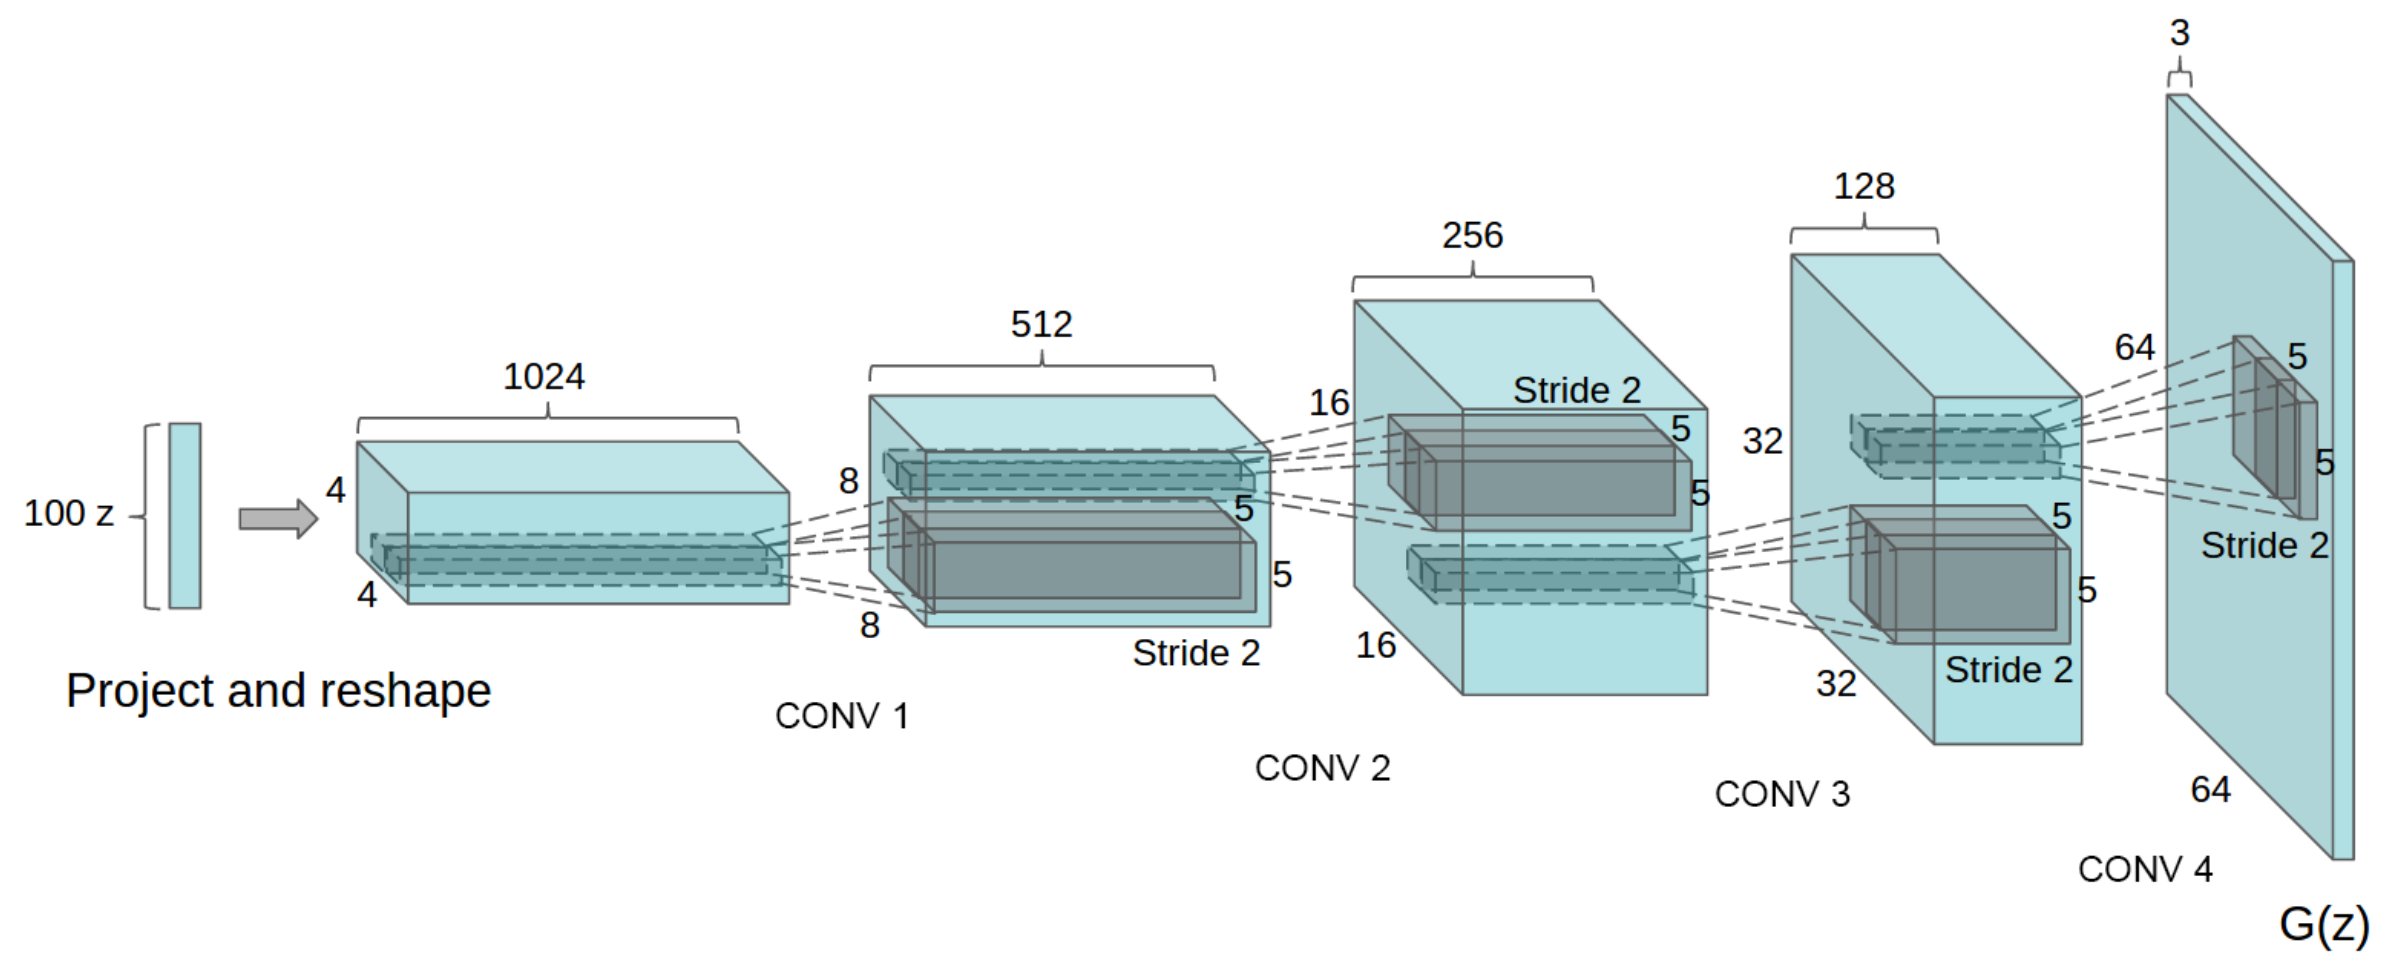

**Figure 1.** The generator network in the DCGAN model (Source).

In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

You can see that we have only convolutional layers in the network.

### **Generator architectural details**

* First, we give the generator a 100-dimensional noise vector as the input.
* After that, we project and reshape the input.
* Then we have four convolution operations. Each time we get an increment in height and width. At the same time, the channels keep on reducing.
* The kernel size will be 4×4.
* After the first convolution operation, we have 512 output channels. This keeps on reducing with each convolution operation. After the third one, the output channels are 128.
* By the end, we have a generated image of 64×64 dimensions and three output channels.
* Except for the first convolution layer, all the other layers have a stride of 2.


In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz # input to the first convolution
        self.main = nn.Sequential(
#         '''
#         YOUR CODE HERE
#         write code for the convolutional layers of the generator
#         use the notes on the technical details of the implementation
#         and the parameters described above
#         '''
         # input is Z, going into a convolution
        nn.ConvTranspose2d(self.nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. ``(ngf*8) x 4 x 4``
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. ``(ngf*4) x 8 x 8``
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. ``(ngf*2) x 16 x 16``
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. ``(ngf) x 32 x 32``
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

## **Discriminator**
The discriminator mode will almost be the reverse of the generator model.
Remember that we need the discriminator to classify whether an image is real (1) or fake (0), so you should choose appropriate activation function on the last layer.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
#             '''
#         YOUR CODE HERE
#         write code for the four convolutional layers of the discriminator
#         use the notes on the technical details of the implementation
#         and the parameters described above
#         '''
        # input is ``(nc) x 64 x 64``
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. ``(ndf) x 32 x 32``
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. ``(ndf*2) x 16 x 16``
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. ``(ndf*4) x 8 x 8``
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. ``(ndf*8) x 4 x 4``
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

    def forward(self, input):
        return self.main(input)

In [6]:
from torchvision.utils import save_image

''' PLEASE DO NOT CHANGE THE CODE OF THIS SECTION'''

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

def weights_init(m):
    """
    This function initializes the model weights randomly from a
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1]. All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02. In the LeakyReLU, the slope of the leak was set to 0.2 in all models. While previous GAN work has used momentum to accelerate training, we used the Adam optimizer (Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. Additionally, we found leaving the momentum term β1 at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

In [7]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from tqdm import tqdm
matplotlib.style.use('ggplot')

# learning parameters / configurations according to described parameters
image_size = 64
batch_size = 128
nz = 100

''' YOUR CODE HERE'''
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 256 # fixed sample size
epochs = 20 # number of epoch to train

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# image transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
    (0.5, 0.5, 0.5)),
])

# prepare the data
train_data = datasets.CIFAR10(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 82096524.53it/s]


Extracting input/data/cifar-10-python.tar.gz to input/data


In [8]:
# initialize generator and discriminator models
''' YOUR CODE HERE'''
generator = Generator(nz).to(device)
discriminator = Discriminator(nz).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))
    
# initialize generator and discriminator weights
''' YOUR CODE HERE'''
# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
generator.apply(weights_init)
discriminator.apply(weights_init)

# Print the model
print(generator,'\n', discriminator)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [9]:
# optimizers for generator and discriminator
''' YOUR CODE HERE'''

# Setup Adam optimizers for both G and D
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# loss function # Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [10]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size).view(-1)
    # get the fake label vector
    fake_label = label_fake(b_size).view(-1)

    optimizer.zero_grad()
        
    # get the outputs by doing real data forward pass
    ''' YOUR CODE HERE'''
    output_real = discriminator(data_real).view(-1)
    loss_real = criterion(output_real, real_label)

    # get the outputs by doing fake data forward pass
    ''' YOUR CODE HERE'''
    output_fake = discriminator(data_fake).view(-1)
    loss_fake = criterion(output_fake, fake_label)

    # compute gradients of real loss
    ''' YOUR CODE HERE'''
    loss_real.backward()
    #D_x = output.mean().item()
    
    # compute gradients of fake loss
    ''' YOUR CODE HERE'''
    loss_fake.backward()
    
    # update discriminator parameters
    ''' YOUR CODE HERE'''
    optimizer.step() #optim_d
    

    return loss_real + loss_fake

In [11]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size).view(-1)

    optimizer.zero_grad()

    # output by doing a forward pass of the fake data through discriminator
    ''' YOUR CODE HERE'''
    output = discriminator(data_fake).view(-1)
    loss = criterion(output, real_label)

    # compute gradients of loss
    ''' YOUR CODE HERE'''
    loss.backward()
    
    # update generator parameters
    ''' YOUR CODE HERE'''
    optimizer.step() #optim_g

    return loss

In [14]:
# create the noise vector
''' YOUR CODE HERE'''
noise = torch.randn(64, nz, 1, 1, device=device)
iters = 0
img_list = []

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        # forward pass through generator to create fake data
        ''' YOUR CODE HERE'''
        data_fake = generator(create_noise(b_size, nz)) #???
        data_real = image
        
        #print(data_fake.shape, '\n', data_real.shape)
        
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz)) # ???
        loss_g += train_generator(optim_g, data_fake)

    # final forward pass through generator to create fake data
    # after training for current epoch
    ''' YOUR CODE HERE'''
    generated_img = generator(noise).detach().cpu() ##vutils.make_grid(data_fake, padding=2, normalize=True)

    # save the generated torch tensor models to disk
    ''' PLEASE DO NOT CHANGE THE CODE OF THIS SECTION'''
    save_generator_image(generated_img, f"outputs/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")
    
    if (iters % 500 == 0) or ((epoch == epochs-1) and (bi == len(train_loader)-1)):
        with torch.no_grad():
            img_list.append(vutils.make_grid(generated_img, padding=2, normalize=True))

    iters += 1

print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), 'outputs/generator.pth')

391it [00:58,  6.64it/s]                         


Epoch 1 of 20
Generator loss: 4.39023542, Discriminator loss: 0.62528211


391it [00:58,  6.65it/s]                         


Epoch 2 of 20
Generator loss: 3.86560631, Discriminator loss: 0.65641779


391it [00:58,  6.68it/s]                         


Epoch 3 of 20
Generator loss: 3.71476007, Discriminator loss: 0.64073086


391it [00:58,  6.70it/s]                         


Epoch 4 of 20
Generator loss: 3.21551204, Discriminator loss: 0.66666144


391it [00:58,  6.71it/s]                         


Epoch 5 of 20
Generator loss: 3.08957863, Discriminator loss: 0.67705894


391it [00:58,  6.65it/s]                         


Epoch 6 of 20
Generator loss: 2.80190182, Discriminator loss: 0.78903574


391it [00:58,  6.67it/s]                         


Epoch 7 of 20
Generator loss: 2.61883759, Discriminator loss: 0.79560220


391it [00:59,  6.62it/s]                         


Epoch 8 of 20
Generator loss: 2.53539038, Discriminator loss: 0.78031504


391it [00:58,  6.69it/s]                         


Epoch 9 of 20
Generator loss: 2.63525796, Discriminator loss: 0.77155691


391it [00:58,  6.66it/s]                         


Epoch 10 of 20
Generator loss: 2.75285339, Discriminator loss: 0.69911760


391it [00:58,  6.63it/s]                         


Epoch 11 of 20
Generator loss: 2.77893639, Discriminator loss: 0.78942990


391it [00:58,  6.71it/s]                         


Epoch 12 of 20
Generator loss: 3.00892687, Discriminator loss: 0.64386445


391it [00:58,  6.64it/s]                         


Epoch 13 of 20
Generator loss: 2.97477889, Discriminator loss: 0.67350966


391it [00:58,  6.69it/s]                         


Epoch 14 of 20
Generator loss: 2.45233941, Discriminator loss: 0.85800540


391it [00:58,  6.70it/s]                         


Epoch 15 of 20
Generator loss: 2.57852960, Discriminator loss: 0.78368586


391it [00:58,  6.70it/s]                         


Epoch 16 of 20
Generator loss: 3.14403272, Discriminator loss: 0.66984046


391it [00:58,  6.63it/s]                         


Epoch 17 of 20
Generator loss: 3.30826592, Discriminator loss: 0.60304517


391it [00:58,  6.68it/s]                         


Epoch 18 of 20
Generator loss: 2.25682044, Discriminator loss: 0.89325559


391it [00:58,  6.69it/s]                         


Epoch 19 of 20
Generator loss: 2.50966501, Discriminator loss: 0.82691181


391it [00:58,  6.71it/s]                         


Epoch 20 of 20
Generator loss: 2.93310094, Discriminator loss: 0.68345439
DONE TRAINING


In [ ]:
# output_real = discriminator(data_real).view(-1)
# loss_real = criterion(output_real, label_real(data_fake.size(0)))
# print(output_real.shape)

In [ ]:
# label_real(data_fake.size(0)).view(-1)

In [ ]:
# print(torch.ones(data_fake.size(0), 1).shape)

In [15]:
# Convert losses variables into numpy arrays for visualization
''' YOUR CODE HERE'''
losses_g_array = [loss_g.detach().cpu().numpy() for loss_g in losses_g]
losses_d_array = [loss_d.detach().cpu().numpy() for loss_d in losses_d]

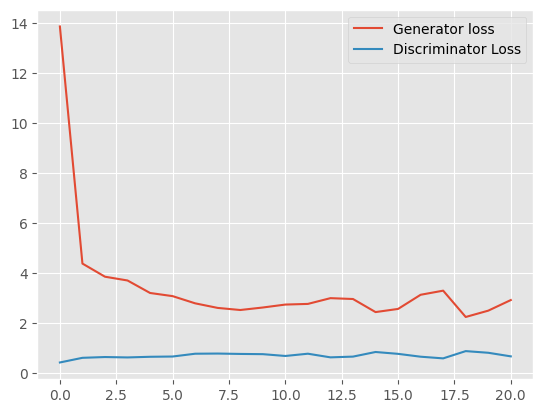

In [16]:
# plot and save the generator and discriminator loss
''' PLEASE DO NOT CHANGE THE CODE OF THIS SECTION'''
plt.figure()
plt.plot(losses_g_array, label='Generator loss')
plt.plot(losses_d_array, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')
plt.show()

***Real Images vs. Fake Images***

Finally, lets take a look at some real images and fake images side by side.

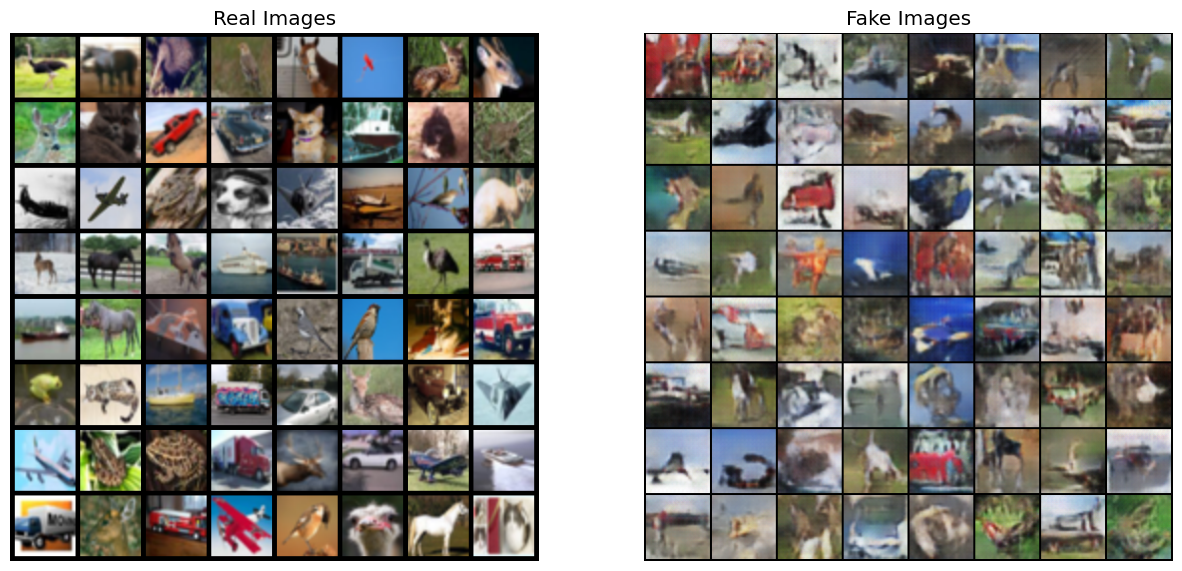

In [17]:
import torchvision.utils as vutils
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()